# Desempeño en Cursos Introductorios de Matemática: Modelos Predictivos
---

In [1]:
# Importar librerias
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

sns.set_style("darkgrid")

In [2]:
# Definir ubicación de archivos
# En Linux/Mac:
# path = r"~/Desktop/Mate_PI/files/"
# En Windows:
path = r"~\OneDrive\Escritorio\Mate_PI\files\\"

mate_pi = pd.read_csv(path + "Mate_PI_full_clean.csv", index_col=0, dtype={"Condicion":"category", "Tipo_Cursada":"category"})

In [3]:
mate_pi.columns

Index(['1P1F', '1P2F', '2P1F', '2P2F', 'F1', 'F2', 'Condicion', 'Final', 'Año',
       'Tipo_Cursada', 'Virtual', 'Oral', 'Grupo'],
      dtype='object')

In [4]:
# Limpieza de columnas:
# 1- No me interesan datos sobre Virtual, Grupo
filtered = mate_pi.drop(columns=["Virtual", "Grupo"])

# 2- Voy a excluir aquellos que hayan Desaprobado en el Oral
filtered = filtered[ filtered["Oral"] != "Desaprobado" ]

# 3- No me interesa la columna Oral
filtered = filtered.drop(columns=["Oral"])

In [5]:
filtered["Tipo_Cursada"].unique()

['Verano', 'Anticipada', '1er Semestre']
Categories (3, object): ['1er Semestre', 'Anticipada', 'Verano']

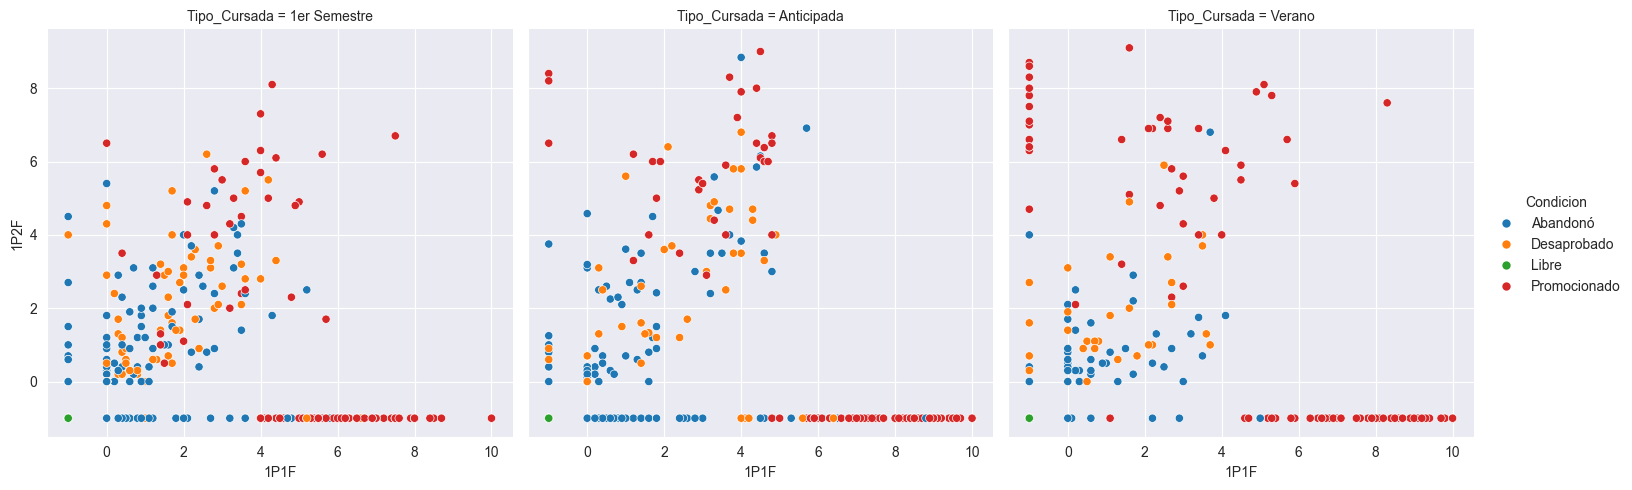

In [6]:
# Inspección de algunas relaciones
sns.relplot(
    data=filtered,
    x="1P1F",
    y="1P2F",
    hue="Condicion",
    col="Tipo_Cursada"
)
plt.show()

In [7]:
# Cantidad de alumnos según Condicion en Verano 2020
mate_pi[ (mate_pi["Tipo_Cursada"]=="Verano") & (mate_pi["Año"]==2020)]["Condicion"].value_counts()

Condicion
Promocionado    44
Abandonó        28
Libre           22
Desaprobado     14
Name: count, dtype: int64

In [8]:
# Proporción de datos mal cargados: Desaprobados Verano 2020 respecto al total de datos de Verano
mate_pi[ mate_pi["Tipo_Cursada"]=="Verano"].info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 0 to 946
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   1P1F          316 non-null    float64 
 1   1P2F          316 non-null    float64 
 2   2P1F          316 non-null    float64 
 3   2P2F          316 non-null    float64 
 4   F1            316 non-null    float64 
 5   F2            316 non-null    float64 
 6   Condicion     316 non-null    category
 7   Final         316 non-null    int64   
 8   Año           316 non-null    int64   
 9   Tipo_Cursada  316 non-null    category
 10  Virtual       316 non-null    int64   
 11  Oral          0 non-null      object  
 12  Grupo         0 non-null      object  
dtypes: category(2), float64(6), int64(3), object(2)
memory usage: 30.6+ KB


In [9]:
14/316

0.04430379746835443

In [10]:
# Corresponde a un 4,4% del total de alumnos del Verano. Voy a implementar data imputation tomandolos como Null values
Verano = filtered[ filtered["Tipo_Cursada"]=="Verano"].copy()
# Reemplazo con NaN los valores desconocidos de Verano 2020
Verano.loc[(Verano["Año"]==2020) & (Verano["Condicion"]=="Desaprobado"), ["1P1F", "1P2F", "2P1F", "2P2F"]] =\
                                Verano.loc[(Verano["Año"]==2020) & (Verano["Condicion"]=="Desaprobado"), ["1P1F", "1P2F", "2P1F", "2P2F"]].replace(0, np.nan)

In [11]:
Verano

,1P1F,1P2F,2P1F,2P2F,F1,F2,Condicion,Final,Año,Tipo_Cursada
0,NaN,NaN,NaN,NaN,-1.0,-1.0,Desaprobado,0,2020,Verano
1,-1.0,7.0,8.2,-1.0,-1.0,-1.0,Promocionado,8,2020,Verano
2,NaN,NaN,NaN,NaN,-1.0,-1.0,Desaprobado,0,2020,Verano
3,NaN,NaN,NaN,NaN,-1.0,-1.0,Desaprobado,0,2020,Verano
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,Libre,0,2020,Verano
...,...,...,...,...,...,...,...,...,...,...
942,0.6,0.3,-1.0,-1.0,-1.0,-1.0,Abandonó,0,2024,Verano
943,10.0,-1.0,10.0,-1.0,-1.0,-1.0,Promocionado,10,2024,Verano
944,2.5,5.9,0.5,3.4,-1.0,2.2,Desaprobado,0,2024,Verano
945,1.8,0.7,0.9,4.0,3.2,-1.0,Desaprobado,0,2024,Verano


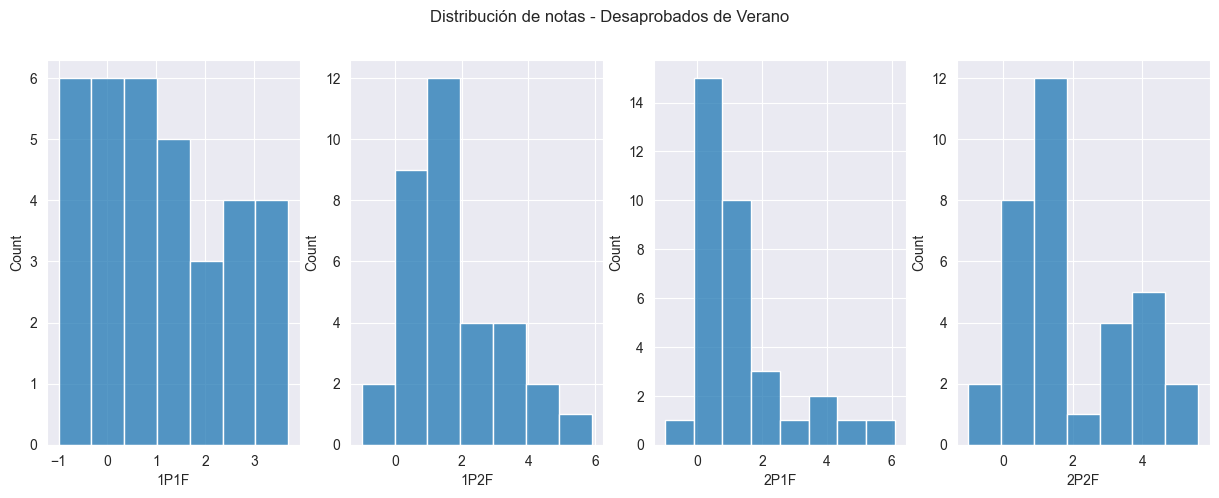

In [12]:
# Distribuciones de notas de Desaprobados en Verano
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15,5))
parciales = ["1P1F", "1P2F", "2P1F", "2P2F"]
for parcial, i in zip(parciales, range(4)):
    data_temp = Verano[Verano["Condicion"]=="Desaprobado"][parcial]
    sns.histplot(
        data=data_temp,
        ax=ax[i]
    )
plt.suptitle("Distribución de notas - Desaprobados de Verano")
plt.show()

In [13]:
Verano[Verano["Condicion"]=="Desaprobado"].describe()

,1P1F,1P2F,2P1F,2P2F,F1,F2,Final,Año
count,34.000000,34.000000,34.000000,34.000000,48.000000,48.000000,48.0,48.000000
mean,1.035294,1.664706,1.202941,1.838235,-0.031250,-0.897917,0.0,2022.291667
std,1.480148,1.532651,1.575472,1.781047,2.155562,0.518381,0.0,1.700542
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.0,2020.000000
25%,0.000000,0.900000,0.025000,0.725000,-1.000000,-1.000000,0.0,2020.000000
50%,0.750000,1.200000,0.900000,1.350000,-1.000000,-1.000000,0.0,2022.000000
75%,2.175000,2.550000,1.575000,3.400000,-1.000000,-1.000000,0.0,2024.000000
max,3.700000,5.900000,6.100000,5.600000,6.300000,2.200000,0.0,2024.000000


In [14]:
# Las notas de Desaprobados de cada parcial siguen distribuciones asimétricas a derecha, excepto 1P1F. 

# Para 1P1F: supongo distribución uniforme, voy a asignar valores aleatorios entre el máximo y el mínimo
max_1 = Verano[Verano["Condicion"]=="Desaprobado"]["1P1F"].max()
min_1 = 0
# Calculo cantidad de nulos en la columna
nulos_1 = Verano[Verano["Condicion"]=="Desaprobado"]["1P1F"].isna().sum()
# Gereno una lista de números aleatorios para reemplazar en NaN:
np.random.seed(2222)
new_values = np.random.uniform(low=min_1, high=max_1, size=nulos_1).round(2)
# Reemplazo con los nuevos valores
Verano.loc[(Verano["Condicion"]=="Desaprobado")&(Verano["1P1F"].isna()), ["1P1F"]] = new_values

# Para los otros parciales, utilizo imputación por mediana:
parciales = ["1P2F", "2P1F", "2P2F"]
for parcial in parciales:
    desaprobados = Verano[Verano["Condicion"]=="Desaprobado"][parcial]
    median = desaprobados.median()
    Verano.loc[(Verano["Condicion"]=="Desaprobado"), [parcial]] = Verano.loc[(Verano["Condicion"]=="Desaprobado"), [parcial]].fillna(median)
Verano

,1P1F,1P2F,2P1F,2P2F,F1,F2,Condicion,Final,Año,Tipo_Cursada
0,2.69,1.2,0.9,1.35,-1.0,-1.0,Desaprobado,0,2020,Verano
1,-1.00,7.0,8.2,-1.00,-1.0,-1.0,Promocionado,8,2020,Verano
2,1.07,1.2,0.9,1.35,-1.0,-1.0,Desaprobado,0,2020,Verano
3,3.14,1.2,0.9,1.35,-1.0,-1.0,Desaprobado,0,2020,Verano
4,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,Libre,0,2020,Verano
...,...,...,...,...,...,...,...,...,...,...
942,0.60,0.3,-1.0,-1.00,-1.0,-1.0,Abandonó,0,2024,Verano
943,10.00,-1.0,10.0,-1.00,-1.0,-1.0,Promocionado,10,2024,Verano
944,2.50,5.9,0.5,3.40,-1.0,2.2,Desaprobado,0,2024,Verano
945,1.80,0.7,0.9,4.00,3.2,-1.0,Desaprobado,0,2024,Verano


In [15]:
# Inserto modificaciones en el DataFrame completo
filtered.loc[(filtered["Tipo_Cursada"]=="Verano")] = Verano

In [16]:
# Elimino la columna de Año
filtered = filtered.drop(columns=["Año"])

In [17]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1203 entries, 0 to 1222
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   1P1F          1203 non-null   float64 
 1   1P2F          1203 non-null   float64 
 2   2P1F          1203 non-null   float64 
 3   2P2F          1203 non-null   float64 
 4   F1            1203 non-null   float64 
 5   F2            1203 non-null   float64 
 6   Condicion     1203 non-null   category
 7   Final         1203 non-null   int64   
 8   Tipo_Cursada  1203 non-null   category
dtypes: category(2), float64(6), int64(1)
memory usage: 77.9 KB


## Preparación del dataset

### Columnas Categóricas: `Tipo_Cursada`

In [18]:
"""
# Opcion Dummy values: Creo dummy values para los Tipos de Cursada
new_columns = pd.get_dummies(filtered["Tipo_Cursada"], drop_first=False, dtype="int")
# Agrego las nuevas columnas pero mantengo la columna original
filtered = pd.concat([filtered, new_columns], axis=1)
"""
# Opción Ordinal Encoder: asigno números a cada Tipo de Cursada
from sklearn.preprocessing import OrdinalEncoder
ord_encoder = OrdinalEncoder()
new_column = ord_encoder.fit_transform(filtered[["Tipo_Cursada"]])

# Asigno los números a una nueva columna: Cursada
filtered["Cursada"] = new_column
filtered

,1P1F,1P2F,2P1F,2P2F,F1,F2,Condicion,Final,Tipo_Cursada,Cursada
0,2.69,1.2,0.9,1.35,-1.0,-1.0,Desaprobado,0,Verano,2.0
1,-1.00,7.0,8.2,-1.00,-1.0,-1.0,Promocionado,8,Verano,2.0
2,1.07,1.2,0.9,1.35,-1.0,-1.0,Desaprobado,0,Verano,2.0
3,3.14,1.2,0.9,1.35,-1.0,-1.0,Desaprobado,0,Verano,2.0
4,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,Libre,0,Verano,2.0
...,...,...,...,...,...,...,...,...,...,...
1218,4.50,-1.0,3.6,7.60,-1.0,-1.0,Promocionado,6,1er Semestre,0.0
1219,2.80,4.0,3.2,6.50,5.5,-1.0,Promocionado,6,1er Semestre,0.0
1220,1.00,1.2,-1.0,-1.00,-1.0,-1.0,Abandonó,0,1er Semestre,0.0
1221,1.20,0.9,0.0,-1.00,-1.0,-1.0,Abandonó,0,1er Semestre,0.0


### Target Feature: `Condicion`

In [19]:
# En principio voy a probar Clasificadores Binarios. Voy a distinguir únicamente entre Promocionados y No Promocionados
filtered["Condicion"] = filtered["Condicion"].astype("str")
filtered["Condicion"] = filtered["Condicion"].replace(to_replace="Promocionado", value=1)
filtered.loc[(filtered["Condicion"]!=1), ["Condicion"]] = 0
filtered["Condicion"] = filtered["Condicion"].astype("int")

In [20]:
# Reviso distribución de valores
filtered.describe()

,1P1F,1P2F,2P1F,2P2F,F1,F2,Condicion,Final,Cursada
count,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000
mean,1.899144,0.426359,1.442976,0.246658,-0.530008,-0.602062,0.287614,2.086451,0.865337
std,3.232509,2.285236,3.320641,2.476724,1.854079,1.649417,0.452839,3.343483,0.801509
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000
50%,0.500000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,1.000000
75%,4.000000,1.000000,3.750000,0.000000,-1.000000,-1.000000,1.000000,6.000000,2.000000
max,10.000000,9.100000,10.000000,9.800000,10.000000,8.900000,1.000000,10.000000,2.000000


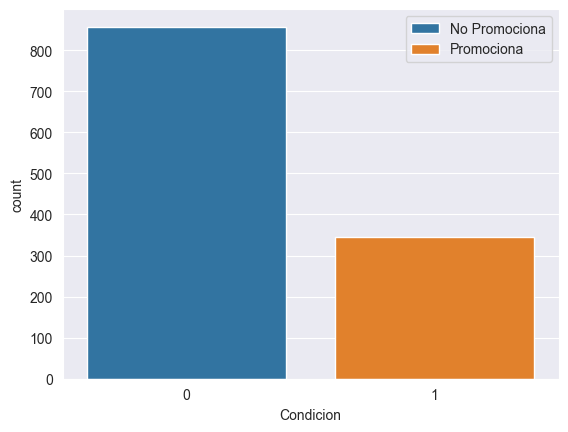

In [21]:
# El target feature está desbalanceado en el dataset: el 28,7% de datos corresponde a Promocionados, el 71.3% restante corresponde a No Promocionados
sns.countplot(data=filtered, x="Condicion", hue="Condicion")
plt.legend(["No Promociona", "Promociona"])
plt.show()

In [22]:
# Dataset modificado y listo para entrenamiento de modelos predictivos
filtered

,1P1F,1P2F,2P1F,2P2F,F1,F2,Condicion,Final,Tipo_Cursada,Cursada
0,2.69,1.2,0.9,1.35,-1.0,-1.0,0,0,Verano,2.0
1,-1.00,7.0,8.2,-1.00,-1.0,-1.0,1,8,Verano,2.0
2,1.07,1.2,0.9,1.35,-1.0,-1.0,0,0,Verano,2.0
3,3.14,1.2,0.9,1.35,-1.0,-1.0,0,0,Verano,2.0
4,-1.00,-1.0,-1.0,-1.00,-1.0,-1.0,0,0,Verano,2.0
...,...,...,...,...,...,...,...,...,...,...
1218,4.50,-1.0,3.6,7.60,-1.0,-1.0,1,6,1er Semestre,0.0
1219,2.80,4.0,3.2,6.50,5.5,-1.0,1,6,1er Semestre,0.0
1220,1.00,1.2,-1.0,-1.00,-1.0,-1.0,0,0,1er Semestre,0.0
1221,1.20,0.9,0.0,-1.00,-1.0,-1.0,0,0,1er Semestre,0.0


## Baseline Model: Logistic Regression 

### Opción: manteniendo proporciones originales de Tipo de Cursada

Voy a entrenar un Logistic Regressor sobre el 80% de los datos, **manteniendo la proporción de Tipo de Cursada**.

#### 1- Crear training y test sets:

In [23]:
# Utilizo Stratified Shuffle Split de scikit-learn para estratificar según Tipo de Cursada, extrayendo el 80% para entrenamiento
from sklearn.model_selection import StratifiedShuffleSplit
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=88)

In [24]:
# Genero dos listas de indices para separar en train y test
indices = splitter.split(filtered, filtered["Tipo_Cursada"])

In [25]:
# Separo en train y test según los índices generados:
for i_train,i_test in indices:
    train_set = filtered.iloc[i_train]
    test_set = filtered.iloc[i_test]

In [26]:
# Verifico proporciones:
print(f"Proporciones: training set - Cant. de datos: {train_set.shape[0]}")
print(train_set["Tipo_Cursada"].value_counts(normalize=True),"\n", "-------------")

print(f"Proporciones: test set - Cant. de datos: {test_set.shape[0]}")
print(test_set["Tipo_Cursada"].value_counts(normalize=True),"\n", "-------------")

print("Proporciones: original set")
print(filtered["Tipo_Cursada"].value_counts(normalize=True))


Proporciones: training set - Cant. de datos: 962
Tipo_Cursada
1er Semestre    0.397089
Anticipada      0.339917
Verano          0.262994
Name: proportion, dtype: float64 
 -------------
Proporciones: test set - Cant. de datos: 241
Tipo_Cursada
1er Semestre    0.398340
Anticipada      0.340249
Verano          0.261411
Name: proportion, dtype: float64 
 -------------
Proporciones: original set
Tipo_Cursada
1er Semestre    0.397340
Anticipada      0.339983
Verano          0.262677
Name: proportion, dtype: float64


**Obtengo 962 datos para entrenamiento, representan aproximadamente un 80% del total de datos disponibles.**

#### 2- Identifico predictores:

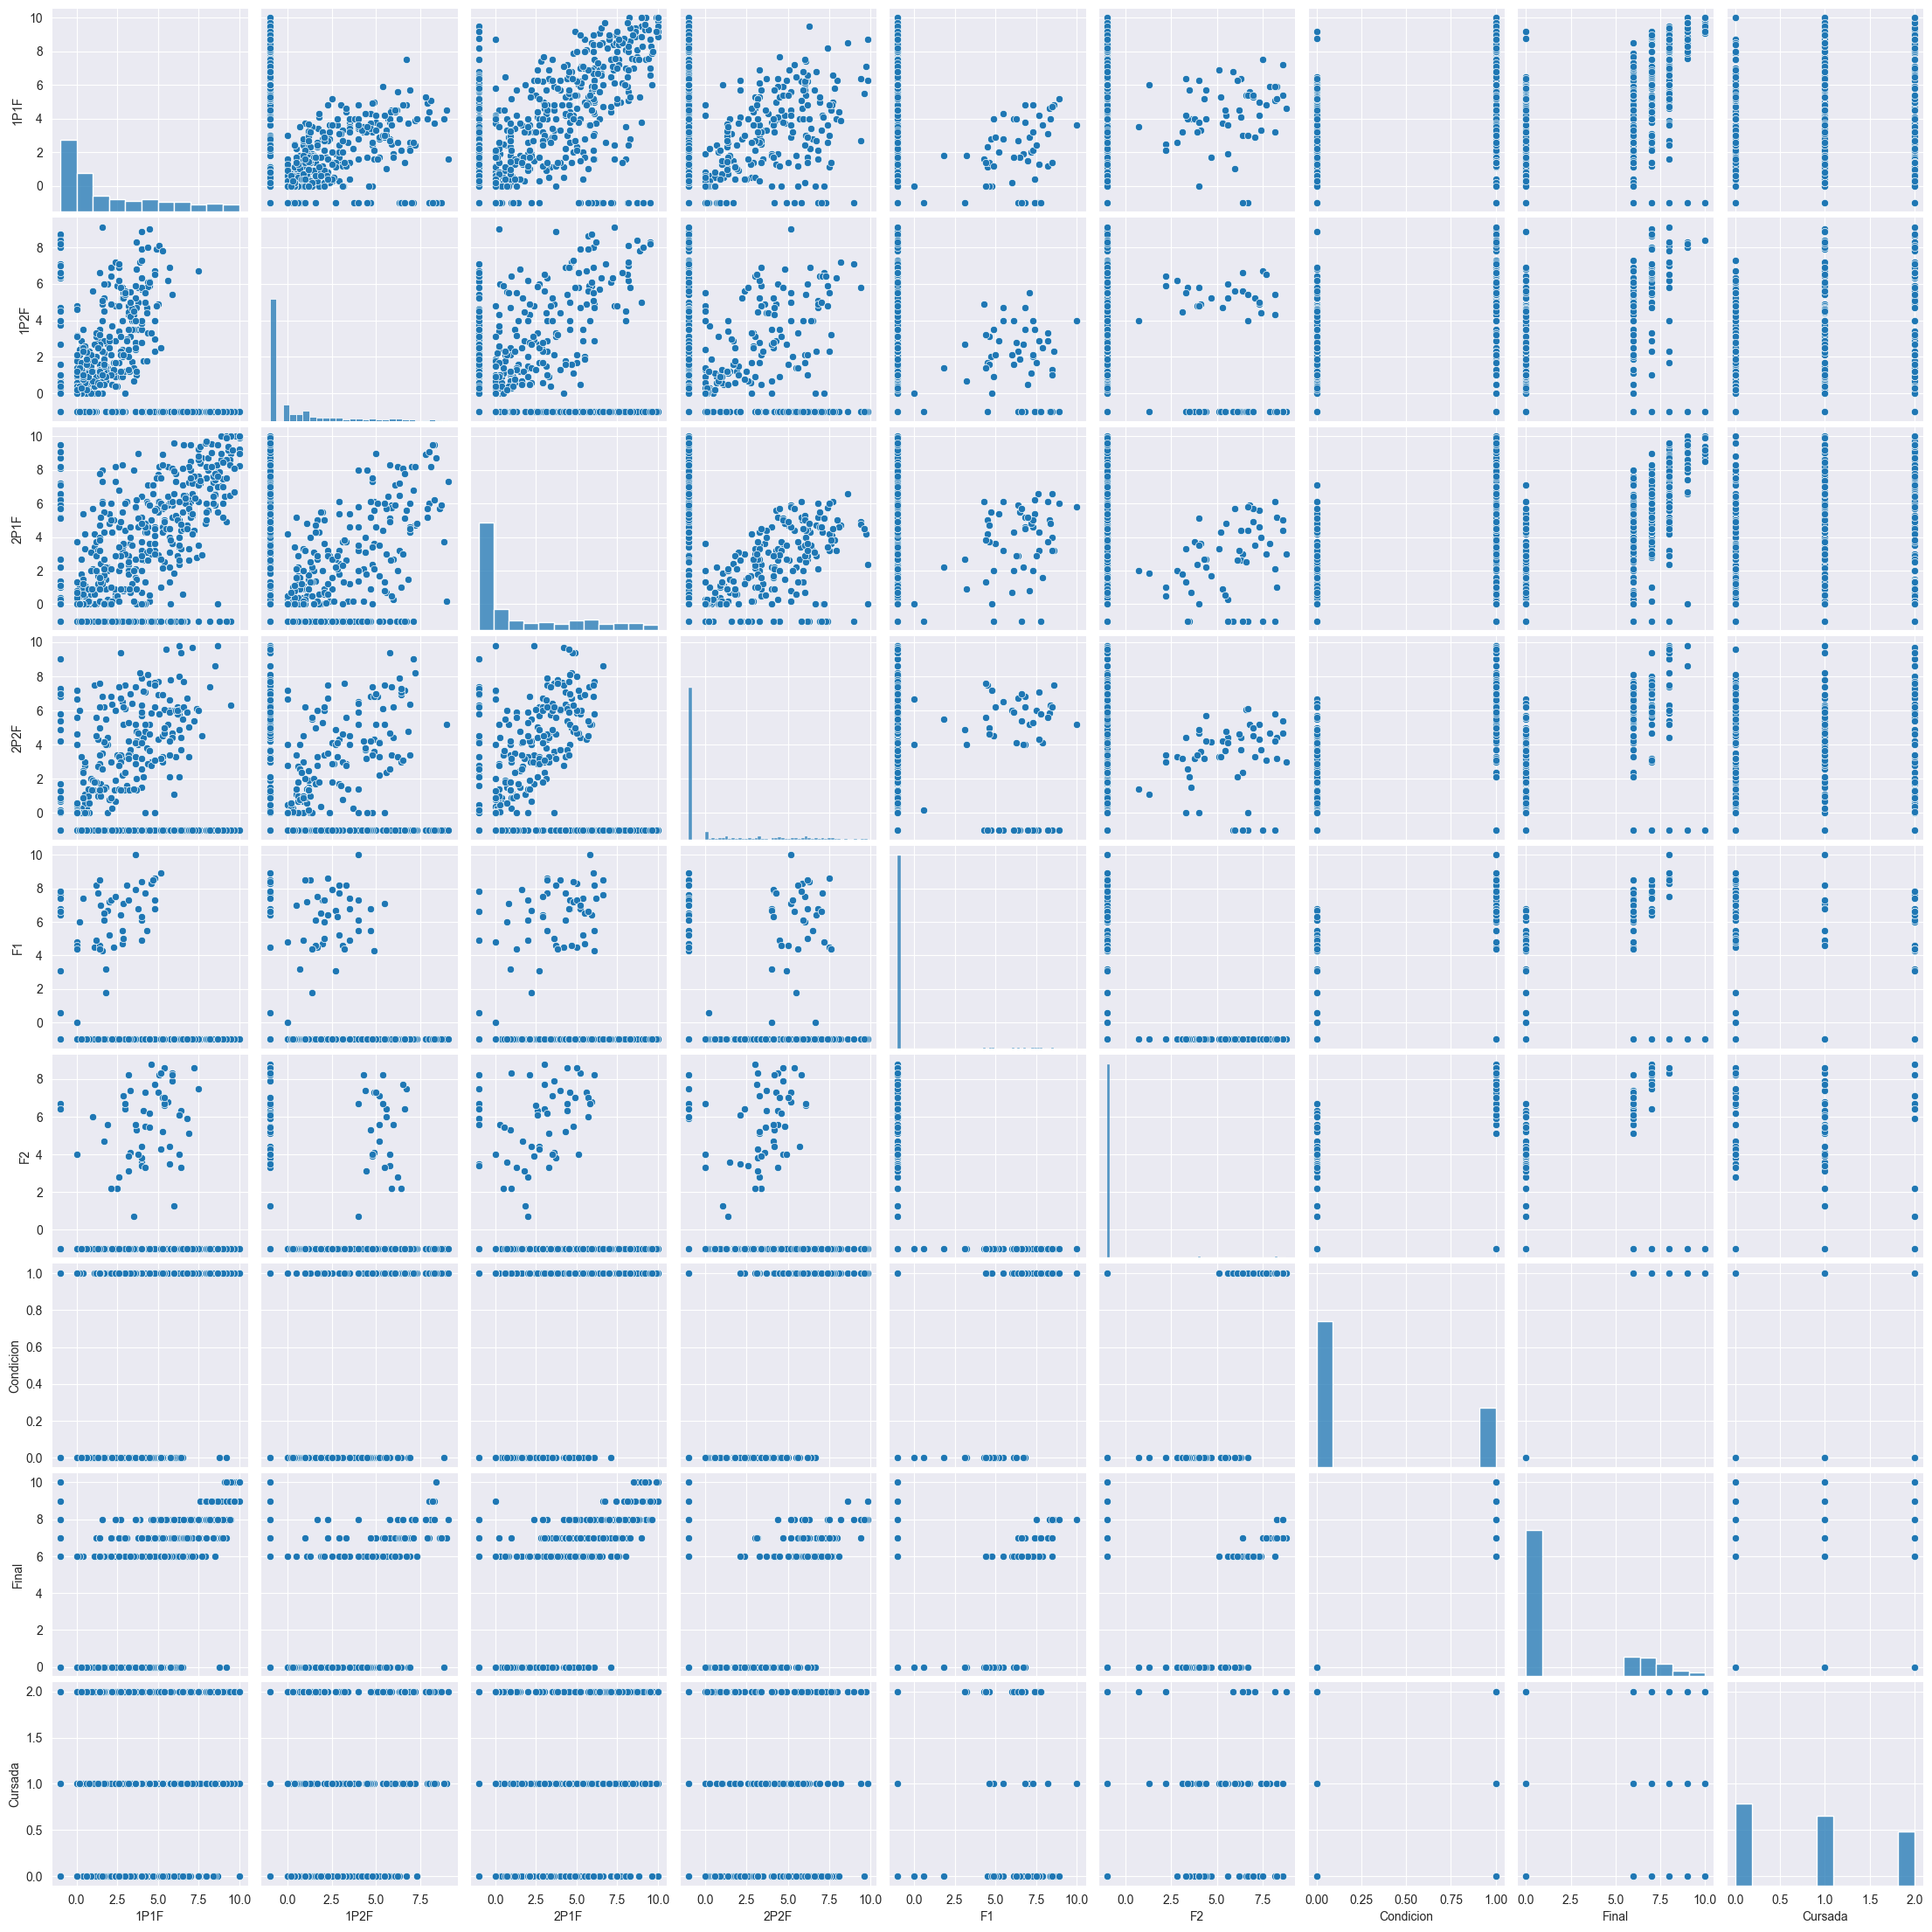

In [27]:
# Efectúo una búsqueda rápida de relaciones entre las columnas disponibles
sns.pairplot(train_set)
plt.show()

- **El atributo *Final* es un fuerte predictor, pero por ser completamente equivalente al target *Condicion***
- Se observa un **desbalance en la proporción de Aprobados y Desaprobados**.
- **Cuidado:** el target es una variable binaria, correlación lineal implica ajustar una Logistic Regression, en los gráficos debería verse como una Sigmoid Function. Eso es lo que se observa entre Condicion y Final.

**Acciones**:

- **Elimino la columna *Final***
- **Elimino la columna *Tipo_Cursada*, que ya no es necesaria**

Luego analizaré la proporción de Aprobados y Desaprobados, de todas maneras no voy a modificar nada respecto a eso.

In [28]:
# Elimino columnas Final y Tipo_Cursada
train_set = train_set.drop(columns=["Final", "Tipo_Cursada"])
test_set = test_set.drop(columns=["Final", "Tipo_Cursada"])

        Condicion
count  962.000000
mean     0.290021
std      0.454008
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000


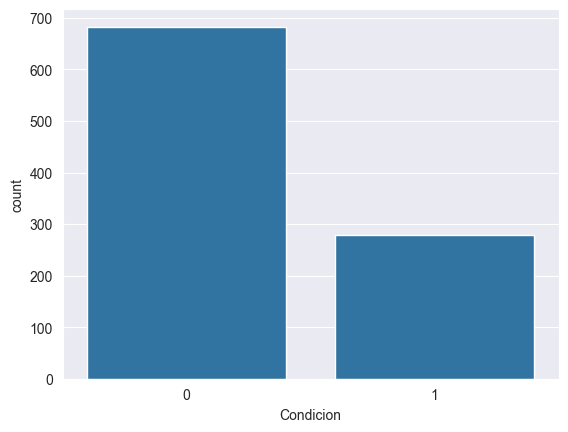

In [29]:
# Analizo la distribución de valores en el target: Condicion
print(train_set[["Condicion"]].describe())
sns.countplot(
    data=train_set,
    x="Condicion")
plt.show()

**El 29% de los datos corresponde a Aprobado. Este desbalance ya se observaba en el dataset original.**

#### 3- Entrenamiento: Logistic Regression sobre el total del training set

----------
**Antes: probando el modelo sólo con dos features**

In [30]:
# Pruebo un modelo sobre sólo 2 features: 1P1F y 2P1F
X = train_set[["1P1F", "2P1F"]].values
y = train_set[["Condicion"]].values
# Cambio dimensión a la target, de vector columna a vector fila
y = np.reshape(y,-1)

log_reg_0 = LogisticRegression()
log_reg_0.fit(X,y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


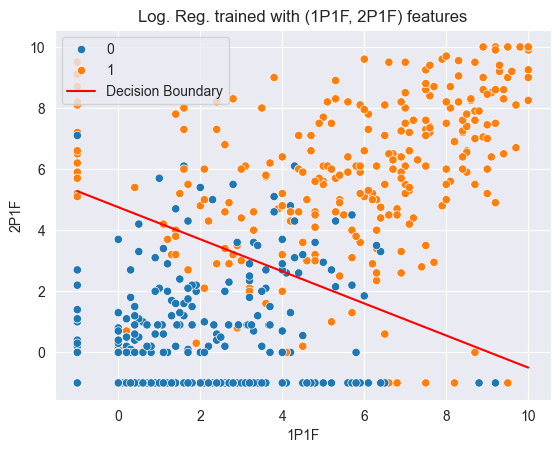

In [31]:
# Miremos la predicción sobre los resultados de 1P1F y 2P1F:
X_1P1F = np.linspace(-1,10,1000)

# Calculo coeficientes:
coefs = log_reg_0.coef_\
                    .reshape(-1) # Convierto a vector fila
b = log_reg_0.intercept_

# Obtengo la Decision Boundary para 2P1F vs 1P1F
X_2P1F = - (coefs[0]/coefs[1])*X_1P1F - b/coefs[1]

sns.scatterplot(data=train_set, x="1P1F", y="2P1F", hue="Condicion")
plt.plot(X_1P1F, X_2P1F, color="red", label="Decision Boundary")
plt.legend()
plt.title("Log. Reg. trained with (1P1F, 2P1F) features")
plt.show()

**Métricas a utilizar para medir rendimiento: Precision, Recall, F1-score**

In [32]:
# Voy a medir Precision y Recall del modelo entrenado, sobre el training set
from sklearn.metrics import classification_report

# Predicciones sobre el training set
y_pred = log_reg_0.predict(X)
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       683
           1       0.87      0.85      0.86       279

    accuracy                           0.92       962
   macro avg       0.91      0.90      0.90       962
weighted avg       0.92      0.92      0.92       962



In [33]:
# Cálculo manual: Precision & Recall
total = y.size
true_pos = 0
false_pos = 0
false_neg = 0

for i in range(total):
    # False Prediction:
    if y[i] != y_pred[i]:
        # False Positive:
        if y_pred[i] == 1:
            false_pos += 1
        # False Negative:
        else:
            false_neg += 1
    # True Prediction:
    else:
        # True Positive:
        if y_pred[i] == 1:
            true_pos += 1
            
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)

print("Precision and Recall: Log. Reg. - First attempt on features (1P1F - 2P1F)")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision and Recall: Log. Reg. - First attempt on features (1P1F - 2P1F)
Precision: 0.87
Recall: 0.85


Obtenemos buenos rendimientos base **entrenando sólo con las primeras fechas de cada parcial**, con **una precisión del 87% y una sensibilidad del 85% sobre el training set.** 

----------
**Continuamos con el plan original: entrenar un modelo de Logistic Regression de baseline y mejorarlo para evitar overfitting**

- Baseline: Log. Reg. sobre todo el training set.
- Revisar distribución de errores con Cross-Validation sobre el training set
- Ajustar hiperparámetros
- **Performance meassurement: F1-score**

In [34]:
# Modelo 0: Logistic Regression sobre el total del training set
X_train_0 = train_set.drop(columns="Condicion").values
y_train_0 = train_set["Condicion"].values

# Cambio dimensión a la target, de vector columna a vector fila
y_train_0 = np.reshape(y_train_0,-1)

log_reg_0 = LogisticRegression()
log_reg_0.fit(X_train_0, y_train_0)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [35]:
# Computo resultados sobre el training set: Precision, Recall, F1_score
y_pred = log_reg_0.predict(X_train_0)

print("RESULTADOS: Modelo 0 - Proporciones originales de TC")
print("-----")
print(f" Precision: {precision_score(y_train_0, y_pred): .2f}", "\n", 
      f"Recall: {recall_score(y_train_0, y_pred): .2f}", "\n",
      f"F1-score: {f1_score(y_train_0, y_pred): .2f}")

RESULTADOS: Modelo 0 - Proporciones originales de TC
-----
 Precision:  0.90 
 Recall:  0.93 
 F1-score:  0.92


In [36]:
# Computo distribución de resultados usando Cross Validation sobre el training set
scores_0 = cross_val_score(
    log_reg_0,
    X_train_0,
    y_train_0,
    cv=10,
    scoring="f1"
)

print("DISTRIBUCION F1 SCORE: Modelo 0")
print(f"Mean: {np.mean(scores_0): .2f}")
print(f"Std. dev.: {np.std(scores_0): .2f}")

DISTRIBUCION F1 SCORE: Modelo 0
Mean:  0.91
Std. dev.:  0.02


**El Modelo 0 es suficientemente bueno: presenta un F1-score aproximado de 0.91, con desviación standard de 0.02, sobre el training set**

Vamos a testear su capacidad de generalización utilizando el test set

In [37]:
# Evalúo Precision, Recall y F1-score sobre el test set
X_test = test_set.drop(columns="Condicion").values
y_test = test_set["Condicion"].values

y_pred_test = log_reg_0.predict(X_test)
precision_0 = precision_score(y_test, y_pred_test)
recall_0 = recall_score(y_test, y_pred_test)
f1_score_0 = f1_score(y_test, y_pred_test)

print("RESULTADOS SOBRE TEST: Modelo 0 - Total del training set")
print("-----")
print(f" Precision: {precision_0: .2f}", "\n", 
      f"Recall: {recall_0: .2f}", "\n",
      f"F1-score: {f1_score_0: .2f}")

RESULTADOS SOBRE TEST: Modelo 0 - Total del training set
-----
 Precision:  0.84 
 Recall:  0.93 
 F1-score:  0.88


Observamos que **el Modelo 0 es capaz de predecir los resultados del test set con un F1-score de 0.88**. Recordemos que habíamos obtenido un F1-score promedio de 0.91 con desviación standard de 0.02, podemos testear si el F1 obtenido es distinto del promedio.

In [38]:
# Calculo p-value, con:
# H0: no hay diferencia entre el promedio y el valor obtenido de F1=0.88. El valor medio es de 0.91, la desviación standard es de 0.02
x_mean = 0.91
std_dev = 0.02
z_score = abs(0.88 - x_mean)/std_dev

from scipy.stats import norm
p_value = 2*(1-norm.cdf(z_score, 0, 1)) 

In [39]:
print(f"p value: {p_value: .2f}")

p value:  0.13


Obtenemos que no hay evidencia para rechazar la hipótesis nula: **el F1-score obtenido de 0.88 no es estadísticamente diferente del promedio de 0.91**, con un nivel de significación del 5%.

### Opción: igual proporción de datos según Tipo de Cursada

Voy a entrenar un Logistic Regressor sobre **un conjunto de datos que contenga igual proporción de datos de cada Tipo de Cursada**.

#### 1. Crear training y test sets:

In [40]:
# Identifico el Tipo de Cursada con menor cantidad de datos
min_cursada = filtered.groupby("Tipo_Cursada",observed=True)["Tipo_Cursada"].count().min()
min_cursada

np.int64(316)

In [41]:
# Train set: utilizo el 85% de la cursada con menos datos y obtengo esa cantidad por cada cursada
n_train = int(0.85*min_cursada)
train_set = filtered.groupby("Tipo_Cursada", observed=True).sample(n=n_train, random_state=10)
# Test set: el resto del dataset
test_set = filtered.drop(labels=train_set.index, axis=0)

In [42]:
# Cuento proporciones de train y test set obtenidos
n_total = train_set.shape[0] + test_set.shape[0]
print(f"Total train: {train_set.shape[0]/n_total:0.2f}")
print(f"Total test: {test_set.shape[0]/n_total:0.2f}")

Total train: 0.67
Total test: 0.33


**Tomando una cantidad de datos del 85% de la Cursada con menos registros, me queda para entrenamiento menos del 70% del total de datos.**

Verificamos proporciones y cantidad de datos:

In [43]:
# Verifico proporciones:
print(f"Proporciones: training set - Cant. de datos: {train_set.shape[0]}")
print(train_set["Tipo_Cursada"].value_counts(normalize=True),"\n", "-------------")

print(f"Proporciones: test set - Cant. de datos: {test_set.shape[0]}")
print(test_set["Tipo_Cursada"].value_counts(normalize=True))

Proporciones: training set - Cant. de datos: 804
Tipo_Cursada
1er Semestre    0.333333
Anticipada      0.333333
Verano          0.333333
Name: proportion, dtype: float64 
 -------------
Proporciones: test set - Cant. de datos: 399
Tipo_Cursada
1er Semestre    0.526316
Anticipada      0.353383
Verano          0.120301
Name: proportion, dtype: float64


#### 2- Identifico predictores:

Como ocurrió anteriormente, la feature *Final* es equivalente al target *Condicion*, y la columna *Tipo_Cursada* ya no será necesaria. **Elimino ambas columnas.**

In [44]:
# Elimino columnas Final y Tipo_Cursada
train_set = train_set.drop(columns=["Final", "Tipo_Cursada"])
test_set = test_set.drop(columns=["Final", "Tipo_Cursada"])

Anaicemos la distribución de Aprobados y Desaprobados para este training set.

        Condicion
count  804.000000
mean     0.304726
std      0.460578
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max      1.000000


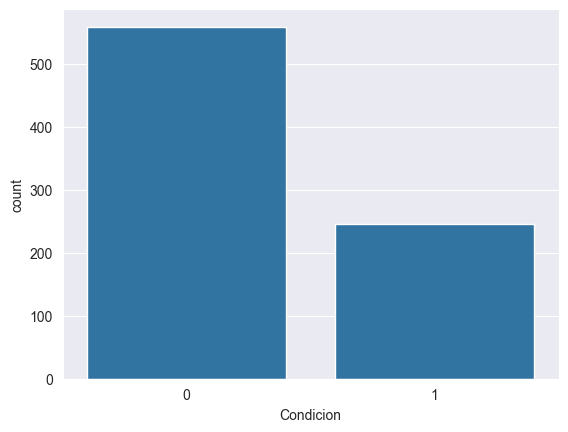

In [45]:
# Analizo la distribución de valores en el target: Condicion
print(train_set[["Condicion"]].describe())
sns.countplot(
    data=train_set,
    x="Condicion")
plt.show()

Obtenemos que **el 30% de los registros en el training set corresponde a Aprobados**. La relación es similar a la que encontramos en el total del dataset, por más que no se mantengan las proporciones originales de Tipo de Cursada.

#### 3- Entrenamiento: Logistic Regressor sobre el total del training set

Entrenaremos un modelo de Logistic Regressor sobre el training set seleccionado

- Baseline: Log. Reg. sobre todo el training set.
- Revisar distribución de errores con Cross-Validation sobre el training set
- Ajustar hiperparámetros, si fuera necesario
- **Performance meassurement: F1-score**

In [46]:
# Modelo 1: Logistic Regression sobre el total del training set
X_train_1 = train_set.drop(columns="Condicion").values
y_train_1 = train_set["Condicion"].values

log_reg_1 = LogisticRegression()
log_reg_1.fit(X_train_1, y_train_1)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [47]:
# Computo resultados sobre el training set: Precision, Recall, F1_score
y_pred = log_reg_1.predict(X_train_1)

print("RESULTADOS: Modelo 1 - Proporciones iguales de TC")
print("-----")
print(f" Precision: {precision_score(y_train_1, y_pred): .2f}", "\n", 
      f"Recall: {recall_score(y_train_1, y_pred): .2f}", "\n",
      f"F1-score: {f1_score(y_train_1, y_pred): .2f}")

RESULTADOS: Modelo 1 - Proporciones iguales de TC
-----
 Precision:  0.90 
 Recall:  0.93 
 F1-score:  0.91


In [48]:
# Computo distribución de resultados usando Cross Validation sobre el training set
scores_1 = cross_val_score(
    log_reg_1,
    X_train_1,
    y_train_1,
    cv=10,
    scoring="f1"
)

print("DISTRIBUCION F1 SCORE: Modelo 1")
print(f"Mean: {np.mean(scores_1): .2f}")
print(f"Std. dev.: {np.std(scores_1): .2f}")

DISTRIBUCION F1 SCORE: Modelo 1
Mean:  0.90
Std. dev.:  0.04


Vamos a testear su capacidad de generalización utilizando el test set

In [49]:
# Evalúo Precision, Recall y F1-score sobre el test set
X_test = test_set.drop(columns="Condicion").values
y_test = test_set["Condicion"].values

y_pred_test = log_reg_1.predict(X_test)
precision_1 = precision_score(y_test, y_pred_test)
recall_1 = recall_score(y_test, y_pred_test)
f1_score_1 = f1_score(y_test, y_pred_test)

print("RESULTADOS SOBRE TEST: Modelo 1 - Total del training set")
print("-----")
print(f" Precision: {precision_1: .2f}", "\n", 
      f"Recall: {recall_1: .2f}", "\n",
      f"F1-score: {f1_score_1: .2f}")

RESULTADOS SOBRE TEST: Modelo 1 - Total del training set
-----
 Precision:  0.85 
 Recall:  0.93 
 F1-score:  0.89


Observamos que **el Modelo 0 es capaz de predecir los resultados del test set con un F1-score de 0.89**. Habíamos obtenido un F1-score promedio de 0.9 con desviación standard de 0.04, podemos testear si el F1 obtenido es distinto del promedio.

In [50]:
# Calculo p-value, con:
# H0: no hay diferencia entre el promedio y el valor obtenido de F1=0.89. El valor medio es de 0.9, la desviación standard es de 0.04
x_mean = 0.9
std_dev = 0.04
z_score = abs(0.89 - x_mean)/std_dev

from scipy.stats import norm
p_value = 2*(1-norm.cdf(z_score, 0, 1)) 

In [51]:
print(f"p value: {p_value: .2f}")

p value:  0.80


Obtenemos que no hay evidencia para rechazar la hipótesis nula: **el F1-score obtenido de 0.89 no es estadísticamente diferente del promedio de 0.9**, con un nivel de significación del 5%.

### Observaciones sobre las dos opciones

Hasta acá hemos entrenado dos modelos similares de Logistic Regressor, modificando únicamente las proporciones en los datos utilizados para entrenamiento:

- *Modelo 0*: entrenado con el 80% del total de datos originales, manteniendo las proporciones de Tipo de Cursada
- *Modelo 1*: entrenado con el 67% del total de datos originales, pero seleccionando igual proporción de datos respecto a Tipo de Cursada

El Modelo 1 podría estar menos sesgado al dataset original, que prepondera alumnos de modalidades Anticipada y 1er Semestre frente a los de las cursadas de Verano. Pero también es menos confiable, al entrenarse con una menor cantidad de datos.

Sin embargo, al comparar los resultados obtenidos en ambos casos, **presentan una performance similar al evaluarse sobre sus propios test sets**:

In [52]:
# Construyo una tabla para comparar resultados
comparativa_0_1 = pd.DataFrame(
    index = ["Modelo 0", "Modelo 1"],
    data = {
        "Precision" : [precision_0, precision_1],
        "Recall" : [recall_0, recall_1],
        "F1 score": [f1_score_0, f1_score_1]
    }
)

comparativa_0_1

,Precision,Recall,F1 score
Modelo 0,0.837838,0.925373,0.879433
Modelo 1,0.854545,0.930693,0.890995


Podemos analizar **la performance de cada uno sobre el total del dataset**:

In [53]:
# Evalúo la predicción de cada modelo sobre el total del dataset:
X_total = filtered.drop(columns = ["Tipo_Cursada", "Final", "Condicion"]).values
y_total = filtered["Condicion"].values

# Predicciones con Modelo 0:
y_pred_0 = log_reg_0.predict(X_total)
# Predicciones con Modelo 1:
y_pred_1 = log_reg_1.predict(X_total)

prediction = [y_pred_0, y_pred_1]

# Construyo tabla comparativa con resultados:
nueva_comparativa_0_1 = pd.DataFrame(columns=["Precision", "Recall", "F1 score"])
for i in range(2):
    nueva_comparativa_0_1.loc[i,"Precision"] = precision_score(y_total, prediction[i])
    nueva_comparativa_0_1.loc[i,"Recall"] = recall_score(y_total, prediction[i])
    nueva_comparativa_0_1.loc[i,"F1 score"] = f1_score(y_total, prediction[i])

In [54]:
nueva_comparativa_0_1

,Precision,Recall,F1 score
0,0.887052,0.930636,0.908322
1,0.884298,0.927746,0.905501


**Nuevamente observamos desempeños similares**, e incluso mejores que al hacerlo sólo sobre los test set, siendo que en el dataset completo se encuentran también todos los datos sobre los que fueron entrenados los modelos.